In [4]:
#Step3a_Raw_DecodingAcc_Subject

#Plotting
import numpy as np

import h5py,pkg_resources,sys,scipy
# import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
import seaborn as sns
# import wbplot
# from wbplot import pscalar
from mpl_toolkits.mplot3d import Axes3D  # This import registers the 3D projection
import plotly.graph_objects as go
# import graphviz
# from graphviz import Digraph



In [5]:
#general python use
import sys
import os,glob,warnings,shutil
import pandas as pd
import mne



In [6]:
import random
from sklearn.ensemble import RandomForestClassifier


In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold


In [8]:
from scipy import signal, stats
import statsmodels.api as sm
from statsmodels.stats.multitest import fdrcorrection
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import MultiComparison
from statsmodels.stats.multitest import multipletests
import math


In [9]:

#Decoders
from sklearn.svm import SVC

#read out matrices to files
import io

#Parallel loop
from concurrent.futures import ProcessPoolExecutor
from joblib import Parallel, delayed


In [10]:
## Set inputs, parms etc
#can use 5, 30, 31, 32, 34, 35
total_subjects = [1,2,3,5,10,16,17,21,34,44] #total_subjects and subjects specification helps load in behav files
#baseDir='/projectsn/f_mc1689_1/cpro2_eeg/'

#path to egi electrode layout (in Fieldtrip templates directory)
elecfile = '/projects/f_mc1689_1/DynamicSensoryMotorEGI/docs/toolboxes/fieldtrip-20170716/template/electrode/GSN-HydroCel-257.sfp';

#condition codes (written in substruct of stim event markers), written here
#for reference
condition_markers = [0,1,2];
condition_names = ['Left','Right','Hand']
condition_array = {}
for i in range(len(condition_markers)):
    condition_array[condition_markers[i]]=condition_names[i]
# condition_array = {condition_markers:condition_names}

#Downsampling rate -- based on Nyquist
downsample_rate =250

#confine to correct trials only
correct_only = 1
if correct_only==1:
    corr_suffix = 'correctOnly'
else:
    corr_suffix = []
    
#**run after creating pseudotrials (sub-averaging trials prior to running
#classification to improve SNR)
run_pseudotrials = 0 #0 = no pseudotrial averaging, 10 = loop over 10 repetitions of pseudotrial averaging
avg_pseudotrials = 14 #*set number of trials within each cond to average over
if run_pseudotrials == 0:
    pseu_suffix = 'noPseudoTrials'
else:
    pseu_suffix = [num2str(run_pseudotrials),'PseudoTrialsAvgOver',num2str(avg_pseudotrials),'Trials']
    
#List classify conditions -- inputs for fxn
#classify_cond = ['Left','Right','Hand']
classify_cond = 'Hand'
#dataset = ['All','Novel','Practice']
dataset = 'All' 
#decoderType = ['SVM','LDA','RandomForest']
decoderType = 'SVM'
#subjects
subjects = total_subjects

#Set validation type --> how are you cross-validating it
validation_type = '10fold'

#Response lock info
resp_pre = 0.5
resp_post = 0.5


In [11]:
#Functions to load data
def read_dataset(ds,k):
    """Reads an HDF5 dataset, resolving references and decoding properly."""

    # If it's a string dataset
    str_info = h5py.check_string_dtype(ds.dtype)
    if str_info is not None:
        return ds.asstr()[()]

    # If it's a compound structured array
    if ds.dtype.names:
        data = {}
        for name in ds.dtype.names:
            field = ds[name][()]
            if np.issubdtype(field.dtype, np.bytes_):
                data[name] = field.astype(str)
            else:
                data[name] = field
        return pd.DataFrame(data)

    # If it's a dataset of references
    if ds.dtype.kind == 'O':
        refs = ds[()]
        if refs.ndim > 0:
            deref_data = []
            for r in refs.flat:
                if isinstance(r, h5py.h5r.Reference):
                    real_obj = ds.file[r]
                    if isinstance(real_obj, h5py.Dataset):
                        deref_data.append(read_dataset(real_obj,k))
                    elif isinstance(real_obj, h5py.Group):
                        deref_data.append(load_group(real_obj,k))
            return deref_data
        else:
            r = refs
            real_obj = ds.file[r]
            if isinstance(real_obj, h5py.Dataset):
                return read_dataset(real_obj,k)
            elif isinstance(real_obj, h5py.Group):
                return load_group(real_obj,k)

    # If it's a regular dataset
    return ds[()]

def load_group(group,k):
    """Recursively loads an HDF5 group into a nested dictionary"""
    result = {}
    try:
        for key, item in group.items():
            if isinstance(item, h5py.Dataset):
                result[key] = read_dataset(item,k)
            elif isinstance(item, h5py.Group):
                result[key] = load_group(item,k)
            else:
                print(f'Unknown item type: {type(item)}')
    except Exception as e:
        print(f'Error {e} occurred for file {k}')
        result[k]=read_dataset(group,k)
    return result

def loadData(dirc, file, fileName):
    """Loads structured HDF5 data safely into nested dictionaries and DataFrames"""
    datafile = f'{dirc}{file}'
    result = {}
    with h5py.File(datafile, 'r') as f:
        keys = list(f.keys())
        print(keys)
        for key in keys:
            result[key] = load_group(f[key],fileName)
    # with h5py.File(datafile, 'r') as f:
    #     result = load_group(f)
    print(f'Finished loading {datafile}')
    return result

def getTrialInfoCols(df, key, mk, lNum):
    """Extracts and reorders trialinfo as necessary"""
    col = df[key][mk][lNum]

    # If it's a list of arrays
    if isinstance(col, list):
        # Flatten and combine them
        new_col = []
        for c in col:
            if isinstance(c, np.ndarray):
                new_col.append(c.flatten()[0])  # Assuming each c is like array([[value]])
            else:
                new_col.append(c)
        return new_col

    # If it's a single array
    elif isinstance(col, np.ndarray):
        return col.flatten()

    else:
        raise TypeError(f"Unexpected type {type(col)} for column")

In [22]:
print(len(label['#refs#']))
print(len(label['label']))

256
1


In [21]:
#TURN THIS INTO A FUNCTION WITH INPUTS classify_cond, dataset, decoderType, and subjNum
subjNum = subjects[1]
#determine values used in classification 
if classify_cond =='Left':
    cond_code = [1,2]
elif classify_cond =='Right':
    cond_code = [3,4]
else:
    cond_code=[1,2,3,4]

#Name directories and make any necessary ones
runFrom = 'FND4' #fnd4 or cpro2_eeg
dataType = 'RawSensor' #sensor or source

if runFrom =='FND4':
    baseDir = '/home/let83/FND4/'
else:
    baseDir = '/projectsn/f_mc1689_1/cpro2_eeg/'
output_dir = f'{baseDir}results/DynamicDecoding/{dataType}/{decoderType}/{classify_cond}/'
output_file = f'_SubjectDecoding_{validation_type}_{classify_cond}_{corr_suffix}_{pseu_suffix}'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
files2load = ['fsample','elec','hdr','trialinfo','sampleinfo','trial','time','label','cfg']
for file in files2load:
    input_dir = f'{baseDir}results/preproc1_causalFilter/sub{subjNum}/'
    input_file = f'{file}_hp0.1notch_seg_autochannelz3_trialz3_ICAz3_baselinelp125avgref.mat'
    #globals()[f'left_{key}']
    try:
        globals()[f'{file}'] = loadData(input_dir,input_file, file)
    except Exception as e:
        print(f'\nERROR: file {file} had error {e}/n')

#Actually Define necessary files (trialinfo, sampleinfo, time, trials)
#Trialinfo
subsystems = (trialinfo['#subsystem#'])
ti = {'TaskCode':[],'acc':[],'resp':[],'rt':[]}
colNames = ['TaskCode','acc','resp','rt']
i=0
for coln in colNames:
    ti[coln] = getTrialInfoCols(subsystems,'MCOS',2,i)
    i+=1
trialinfo = pd.DataFrame(ti)
#Trials
trial.keys()
nChans = 251
nTimepoints = 3945
nTrial = 360
trials_real = np.zeros((nTimepoints, nChans, nTrial))
tkeys = list(trial['#refs#'].keys()) #Each key is a trial
for tnum in range(360):
    try:
        tk = tkeys[tnum]
        trials_real[:,:,tnum] = trial['#refs#'][tk]
    except Exception as e:# one row should not have the right dimensions as there are 361 keys and only 360 trials
        print(f'ERROR {e} at {tkeys[tnum]},{tnum}!!!\n')
#Define samples 
samples = pd.DataFrame({'Start':sampleinfo['sampleinfo']['sampleinfo'][0],'End':sampleinfo['sampleinfo']['sampleinfo'][1]})
#Time and trialinfo need to be in the same format
time_df = pd.DataFrame()
for i in range(360):
    newTrial = pd.DataFrame(list(time['time']['time'][i]))
    nt = newTrial.T
    time_df = pd.concat([time_df,nt],ignore_index=False)


['fsample']
Error 'Dataset' object has no attribute 'items' occurred for file fsample
Finished loading /home/let83/FND4/results/preproc1_causalFilter/sub2/fsample_hp0.1notch_seg_autochannelz3_trialz3_ICAz3_baselinelp125avgref.mat
['#refs#', 'elec']
Finished loading /home/let83/FND4/results/preproc1_causalFilter/sub2/elec_hp0.1notch_seg_autochannelz3_trialz3_ICAz3_baselinelp125avgref.mat
['#refs#', 'hdr']
Finished loading /home/let83/FND4/results/preproc1_causalFilter/sub2/hdr_hp0.1notch_seg_autochannelz3_trialz3_ICAz3_baselinelp125avgref.mat
['#refs#', '#subsystem#', 'trialinfo']
Error 'Dataset' object has no attribute 'items' occurred for file trialinfo
Finished loading /home/let83/FND4/results/preproc1_causalFilter/sub2/trialinfo_hp0.1notch_seg_autochannelz3_trialz3_ICAz3_baselinelp125avgref.mat
['sampleinfo']
Error 'Dataset' object has no attribute 'items' occurred for file sampleinfo
Finished loading /home/let83/FND4/results/preproc1_causalFilter/sub2/sampleinfo_hp0.1notch_seg_auto

In [24]:
#Response Lock Data
data_resp = {'trialinfo':trialinfo,
             'sampleinfo':samples, 
             'time' : time_df,
             'trial': []}
skipped_trials = []
resp_secs = pd.DataFrame()
time_new = pd.DataFrame()
for t in range(len(trialinfo['rt'])):
    start_resp=(trialinfo['rt'][t]/1000)-resp_pre #RT-500
    end_resp=(trialinfo['rt'][t]/1000)+resp_post #RT+500
    newRow = pd.DataFrame({'Start':[start_resp], 'End':[end_resp]})
    # print(newRow)
    resp_secs=pd.concat([resp_secs,newRow],ignore_index=False)
    #find start and end inds in .time (round to deal with floating point discrepancies)
    times = time_df.iloc[t].values
    start_ind=np.where(np.round(times, 3) == np.round(start_resp, 3))[0]
    end_ind = np.where(np.round(times, 3) == np.round(end_resp, 3))[0]
    
    if len(start_ind) == 0 or len(end_ind) == 0:
        print(f"Warning: No matching start or end index for trial {t}. Skipping trial.")
        skipped_trials.append(t)
        continue  # skip this trial

    #*seems like fieldtrip call to redefinetrial includes epoch end timepoints for stim-locked data; 
    #hence for consistency not removing the last ind for resp_locked
    #use inds to reference data_input.trial
    # print(start_ind)
    time_row = pd.DataFrame(list(np.arange(-0.5, 0.5, 0.001))).T
    time_new = pd.concat([time_new,time_row],ignore_index=False)
    #print(time_new)
    trl = trials_real[:, :, t]  # (channels, timepoints)
    trl = trl[start_ind[0]:end_ind[0]+1,:]  # +1 to include endpoint like MATLAB
    #print(trl)
    # Append to data_resp['trial']
    data_resp['trial'].append(trl)

# Update the time field for each trial (optional)
data_resp['time'] = time_new
# Step 3: Final assignment
data_input = data_resp

In [25]:
##Dynamic Decoding Preproc
# organize trial data so it is in the format (timepoints, channels) --> (n_trials, n_channels, n_timepoints)
data_stack = np.stack(data_resp['trial'], axis=0) 
data_for_resample = np.transpose(data_stack, (0, 2, 1))

# resample trials
resampled_data = mne.filter.resample(data_for_resample, up=1, down=4, axis=-1)

# update data_resp to reflect downsampling
data_resp['trial'] = resampled_data
print(resampled_data.shape)

(359, 251, 250)


In [26]:
##Sort trials that will be classified
cond_info = trialinfo[(trialinfo['acc'] == 1) & (trialinfo['resp'].isin(cond_code))].reset_index(drop=True)
cond_idx = cond_info.index.tolist()

print(len(cond_idx))


319


In [27]:
if classify_cond=='Left':
    cond_targets = cond_info[:]['resp']
elif classify_cond=='Right':
    cond_targets = []
    for i in range(len(cond_info)):
        if cond_info.iloc[i]['resp'] == 3:
            cond_targets.append(1)
        elif cond_info.iloc[i]['resp'] == 4:
            cond_targets.append(2)
elif classify_cond=='Hand':
    cond_targets = []
    for i in range(len(cond_info)):
        if cond_info.iloc[i]['resp'] == 3:
            cond_targets.append(1)
        elif cond_info.iloc[i]['resp'] == 4:
            cond_targets.append(2)
        elif cond_info.iloc[i]['resp']==1:
            cond_targets.append(1)
        else:
            cond_targets.append(2)

In [28]:
#Time lock the data

#make/organize data necessary for mne timelocking function 
#data (trial x channels x time)
#is resampled_data --> no reorganization needed

#Info abt electrodes and data collection
print(resampled_data.shape)
n_channels = resampled_data.shape[1]

print(n_channels)
sfreq = 250  # sampling frequency after downsampling
ch_names = [f'EEG {i:03d}' for i in range(n_channels)]
#print(ch_names)
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types='eeg')

#events (trial number x dummy col x event ID)
n_trials = resampled_data.shape[0]
events = np.column_stack((np.arange(n_trials), np.zeros(n_trials, dtype=int), np.ones(n_trials, dtype=int)))
print(resampled_data.shape)
#Timelock data
data_trl = mne.EpochsArray(resampled_data, info, events=events, event_id={'response': 1}, tmin=-0.5)
print(data_trl.get_data().shape)



(359, 251, 250)
251
(359, 251, 250)
Not setting metadata
Not setting metadata
359 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
(359, 251, 250)


In [29]:
print(data_trl)
print(data_trl.times.shape)
print(data_trl.times[:10])  # first 10 timepoints
print(data_trl.times[-10:])  # last 10 timepoints

<EpochsArray |  359 events (all good), -0.5 - 0.496 sec, baseline off, ~172.1 MB, data loaded,
 'response': 359>
(250,)
[-0.5   -0.496 -0.492 -0.488 -0.484 -0.48  -0.476 -0.472 -0.468 -0.464]
[0.46  0.464 0.468 0.472 0.476 0.48  0.484 0.488 0.492 0.496]


In [30]:
##### set up trl_data and cond targets to run through decoder
#Define cond target indices 
xx_cond_inds = random.sample(range(len(cond_targets)), len(cond_targets))


In [33]:
#Make randomized cond targets
random_cond_targets = []
for i in xx_cond_inds:
    random_cond_targets.append(cond_targets[i])
# #make data structure for each condition
nChans = 251
nTimepoints = 250
# print(len(xx_cond_inds))
# cond1_trls = np.zeros((len(xx_cond_inds), nChans, nTimepoints))
# cond1 = []
# cond2_trls = []

In [35]:
# Loop over each randomized index
random_data_trl = np.zeros((len(xx_cond_inds), nChans, nTimepoints))
trial_num = 0
for idx in xx_cond_inds:
    trlData = data_trl.get_data()[idx]     # pull trial data
    # print(trl.shape)
    random_data_trl[idx, :, :] = trlData   # final shape = (319, 251, 250) --> should be 319, 250

#random_data_trl_final = random_data_trl.reshape(random_data_trl.shape[0], -1)  # shape becomes (319, 251*250)


In [36]:
#Set up Dynamic Decoding
# Define necessary aspects of decoding, classification, and folds
clf = SVC(kernel='linear')
#Set up basic variables
nFolds = 10
nTimepoints = 250
# Set up 10-fold Stratified Cross Validation
cv = StratifiedKFold(n_splits=nFolds, shuffle=True, random_state=42)

# matrix to collect accuracy info
n_timepoints = np.array([i for i in range(250)])
tempGenAcc = np.zeros((nTimepoints,nTimepoints))



In [37]:
#Determine folds before entering loop
X = random_data_trl[:, :, 1]
folds_mat = []
for train, test in cv.split(X, random_cond_targets):
    folds_mat.append((train,test))

In [ ]:
# Prepare to collect predictions
y_preds = []  # Will be a list of arrays
y_tests = []
#Convert targets to a numpy array to fix indexing problem 
random_cond_targets = np.array(random_cond_targets)
accuracy_timepoint = np.zeros((nTimepoints))

for t in range(nTimepoints):
    # Extract data at time t across all trials
    # Shape: (n_trials, n_channels) --> perform classification on a time point instead a trial
    X = random_data_trl[:, :, t]  
    # 10-fold cross-validation
    accuracies = []
    for train_idx, test_idx in folds_mat:
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = random_cond_targets[train_idx], random_cond_targets[test_idx]

        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        accuracies.append(acc)

    # Mean cross-validated accuracy at this timepoint
    accuracy_timepoint[t] = np.mean(accuracies)
    

In [40]:
# Assume: random_data_trl, random_cond_targets, folds_mat already defined
nTimepoints = random_data_trl.shape[2]

clf = SVC(kernel='linear')
nFolds = len(folds_mat)  # should be 10

# Preallocate result
accuracy_timepoint = np.zeros((nTimepoints,))

# Parallel version
def decode_single_timepoint(t):
    X = random_data_trl[:, :, t]
    accuracies = []
    for train_idx, test_idx in folds_mat:
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = random_cond_targets[train_idx], random_cond_targets[test_idx]
        
        # Initialize a NEW classifier each time (important!)
        clf_t = SVC(kernel='linear')
        clf_t.fit(X_train, y_train)
        y_pred = clf_t.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        accuracies.append(acc)
    return np.mean(accuracies)

n_jobs = -1  # Use all CPUs
results = Parallel(n_jobs=n_jobs)(delayed(decode_single_timepoint)(t) for t in range(nTimepoints))

# Collect results
accuracy_timepoint = np.array(results)

In [51]:
#Save output
avg_accuracy = pd.DataFrame(accuracy_timepoint)
full_path = os.path.join(output_dir, f'{subjNum}{output_file}.csv')
avg_accuracy.to_csv(full_path, index=False)


In [43]:
#Visualize
if classify_cond=='Left' or classify_cond=='Right':
    title = f'{classify_cond} Hand {decoderType} Finger Decoding\nAccuracy of Subject {subjNum}'
    outfile = f'{classify_cond}_Hand_{decoderType}_Finger_Decoding_Accuracy_of_Subject{subjNum}'
elif classify_cond=='Hand':
    title = f'Hand {decoderType} Decoding Accuracy of Subject {subjNum}'
    outfile = f'Hand_{decoderType}_Decoding_Accuracy_of_Subject{subjNum}'


Text(0, 0.5, 'Decoding Accuracy')

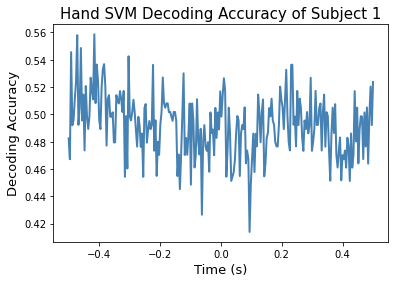

In [44]:
timepoints = np.linspace(-0.5, 0.5, nTimepoints)
plt.figure()
plt.plot(timepoints,accuracy_timepoint, color='steelblue', linewidth=2)
# plt.fill_between(timepoints, np.array(accuracy_timepoint) - np.array(sem_accuracy), np.array(accuracy_timepoint) + np.array(sem_accuracy), alpha=0.3, color='lightskyblue')
plt.title(title, fontsize=15) 
plt.xlabel('Time (s)', fontsize=13)
plt.ylabel('Decoding Accuracy', fontsize=13)
# plt.savefig(os.path.join(outputDir, outfile))
# plt.show()

In [42]:
print(decoderType)
print(subjNum)
print(classify_cond)
print(accuracy_timepoint)

SVM
1
Hand
[0.48245968 0.4671371  0.54556452 0.49203629 0.49576613 0.5108871
 0.52358871 0.55796371 0.49233871 0.50483871 0.54858871 0.49556452
 0.51451613 0.47358871 0.52076613 0.4984879  0.48931452 0.49879032
 0.52681452 0.51743952 0.5109879  0.55866935 0.50826613 0.53649194
 0.52429435 0.49576613 0.48921371 0.52076613 0.53336694 0.53679435
 0.52046371 0.47711694 0.51139113 0.5141129  0.49828629 0.49828629
 0.5015121  0.47943548 0.47953629 0.5140121  0.51038306 0.50796371
 0.51703629 0.51108871 0.50171371 0.5171371  0.45423387 0.49868952
 0.46038306 0.54254032 0.4984879  0.49556452 0.50181452 0.51068548
 0.5015121  0.48921371 0.47641129 0.49818548 0.49203629 0.47620968
 0.4859879  0.45423387 0.5046371  0.50756048 0.47933468 0.48881048
 0.49516129 0.4891129  0.4921371  0.53629032 0.4733871  0.49566532
 0.45493952 0.47993952 0.4703629  0.49254032 0.50181452 0.52701613
 0.50806452 0.50483871 0.50806452 0.50806452 0.5016129  0.50181452
 0.49858871 0.4952621  0.50181452 0.50171371 0.49536

In [ ]:
#Save output
avg_accuracy = pd.DataFrame(accuracy_timepoint)
avg_accuracy.to_csv(f'{output_file}.csv', index=False) 

In [ ]:
#Temporal Generalization
#Set up Dynamic Decoding
# Train a linear SVM classifier on train data
clf = SVC(kernel='linear')

# Set up 5-fold Stratified Cross Validation
cv = StratifiedKFold(n_splits=nFolds, shuffle=True, random_state=42)

# matrix to collect accuracy info
n_timepoints = np.array([i for i in range(250)])
tempGenAcc = np.zeros((nTimepoints,nTimepoints))

#Determine folds before entering loop
X = random_data_trl[:, :, 1]
folds_mat = []
for train, test in cv.split(X, random_cond_targets):
    folds_mat.append((train,test))

# Make function to run temporal generalization 
def decode_TempGen(t_train, nTimepoints):
    X_train_data = random_data_trl[:, :, t_train]
    for t in range(nTimepoints):
        # Extract data at time t across all trials
        # Shape: (n_trials, n_channels) --> perform classification on a time point instead a trial
        X = random_data_trl[:, :, t]
        # 10-fold cross-validation
        accuracies = []
        for train_idx, test_idx in folds_mat:
            X_train, X_test = X_train_data[train_idx], X[test_idx]
            y_train, y_test = random_cond_targets[train_idx], random_cond_targets[test_idx]

            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            acc = accuracy_score(y_test, y_pred)
            accuracies.append(acc)

        # Mean cross-validated accuracy at this timepoint
        tempGenAcc[t_train,t]=np.mean(accuracies)

    return tempGenAcc

#run temporal generalization decoding analysis in parallel
n_jobs = -1  # Use all CPUs
tempGenAcc[:,:] = Parallel(n_jobs=n_jobs)(delayed(decode_TempGen)(t,nTimepoints) for t in range(nTimepoints))



# for t_train in n_timepoints:
#     # Extract data at time t across all trials
#     X_train_data = random_data_trl[:, :, t_train]
#     for t in range(nTimepoints):
#         # Extract data at time t across all trials
#         # Shape: (n_trials, n_channels) --> perform classification on a time point instead a trial
#         X = random_data_trl[:, :, t]
#         # 10-fold cross-validation
#         accuracies = []
#         for train_idx, test_idx in folds:
#             X_train, X_test = X_train_data[train_idx], X[test_idx]
#             y_train, y_test = random_cond_targets[train_idx], random_cond_targets[test_idx]

#             clf.fit(X_train, y_train)
#             y_pred = clf.predict(X_test)
#             acc = accuracy_score(y_test, y_pred)
#             accuracies.append(acc)

#         # Mean cross-validated accuracy at this timepoint
#         tempGenAcc[t_train,t]=np.mean(accuracies)



In [ ]:

# X = random_data_trl[:, :, 1]
# folds_mat = []
# for train, test in cv.split(X, random_cond_targets):
#     folds_mat.append((train,test))

# for t_train in n_timepoints:
#     # Extract data at time t across all trials
#     X_train_data = random_data_trl[:, :, t_train]
#     for t in range(nTimepoints):
#         # Extract data at time t across all trials
#         # Shape: (n_trials, n_channels) --> perform classification on a time point instead a trial
#         X = random_data_trl[:, :, t]
#         # 10-fold cross-validation
#         accuracies = []
#         for train_idx, test_idx in folds:
#             X_train, X_test = X_train_data[train_idx], X[test_idx]
#             y_train, y_test = random_cond_targets[train_idx], random_cond_targets[test_idx]

#             clf.fit(X_train, y_train)
#             y_pred = clf.predict(X_test)
#             acc = accuracy_score(y_test, y_pred)
#             accuracies.append(acc)

#         # Mean cross-validated accuracy at this timepoint
#         tempGenAcc[t_train,t]=np.mean(accuracies)


In [ ]:
if classify_cond=='Left' or classify_cond=='Right':
    title = f'Temporal Generalization of {classify_cond} Hand\n{decoderType} Finger Decoding Accuracy of Subject {subjNum}'
    #outfile = f'TempGen_{classify_cond}_Hand_{decoderType}_Finger_Decoding_Accuracy_of_Subject{subjNum}'
elif classify_cond=='Hand':
    title = f'Temporal Generalization of Hand {decoderType} Decoding Accuracy of Subject {subjNum}'
    outfile = f'TempGen_Hand_{decoderType}_Decoding_Accuracy_of_Subject{subjNum}'
nTimepoints = tempGenAcc.shape[0]
timepoints = np.linspace(-0.5, 0.5, nTimepoints)
plt.figure(figsize=(8,6))
        #Plot matrix with matrix time points
plt.imshow(tempGenAcc, aspect='auto', cmap='viridis', origin='lower',
            extent=[timepoints[0], timepoints[-1], timepoints[0], timepoints[-1]])
plt.colorbar(label='Decoding Accuracy')
plt.xlabel('Test Timepoints',fontsize=13)
plt.ylabel('Train Timepoints',fontsize=13)
plt.title(title, fontsize=15)
        #Make a white line where the response happens
plt.axhline(0, color='white', linestyle='--')
plt.axvline(0, color='white', linestyle='--')
#plt.savefig(os.path.join(outputDir, outfile))
plt.show()